# 2-2. 答案

Cats vs Dogs Kaggle competition:

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for kaggle-catsanddogs.zip (1 = dog, 0 = cat).

dataset url: http://aimaksen.bslience.cn/kaggle-catsanddogs.zip

- val acc > 97%
- epoch <= 25

附加思考:
- filter 的大小的作用是什么
- 卷积核数量
- mean pooling 和 max pooling 的区别

In [1]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import pathlib

import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
tf.config.experimental.set_visible_devices(devices=gpus[3], device_type="GPU")

In [2]:
# This code block downloads the full Cats-v-Dogs dataset and stores it

path_to_file = tf.keras.utils.get_file(
    "kaggle-catsanddogs.zip",
    cache_subdir="kaggle-catsanddogs",
    origin="http://aimaksen.bslience.cn/kaggle-catsanddogs.zip",
    extract=True,
)

data_dir = pathlib.Path(path_to_file).parent / "PetImages"
data_dir

PosixPath('/root/.keras/kaggle-catsanddogs/PetImages')

In [3]:
sharped_train_path = data_dir.parent / "sharped_train"
sharped_train_path.mkdir(parents=True, exist_ok=True)
sharped_train_dog_path = data_dir.parent / "sharped_train" / "Dog"
sharped_train_dog_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# 数据锐化
from tqdm import tqdm

for i in tqdm(range(len(os.listdir(data_dir / "Dog")))):
    pic_path = data_dir / "Dog" / os.listdir(data_dir / "Dog")[i]
    try:
        pic = PIL.Image.open(pic_path)
        pic_sharp = pic.filter(PIL.ImageFilter.UnsharpMask(radius=2, percent=100))
        preprocessed_pic_path = (
            sharped_train_path / "Dog" / os.listdir(data_dir / "Dog")[i]
        )
        pic_sharp.save(preprocessed_pic_path)
    except:
        pass

In [4]:
sharped_train_cat_path = data_dir.parent / "sharped_train" / "Cat"
sharped_train_cat_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# 数据锐化
for i in tqdm(range(len(os.listdir(data_dir / "Cat")))):
    pic_path = data_dir / "Cat" / os.listdir(data_dir / "Cat")[i]
    try:
        pic = PIL.Image.open(pic_path)
        pic_sharp = pic.filter(PIL.ImageFilter.UnsharpMask(radius=2, percent=100))

        preprocessed_pic_path = (
            sharped_train_path / "Cat" / os.listdir(data_dir / "Cat")[i]
        )
        pic_sharp.save(preprocessed_pic_path)
    except:
        pass

(-0.5, 499.5, 374.5, -0.5)

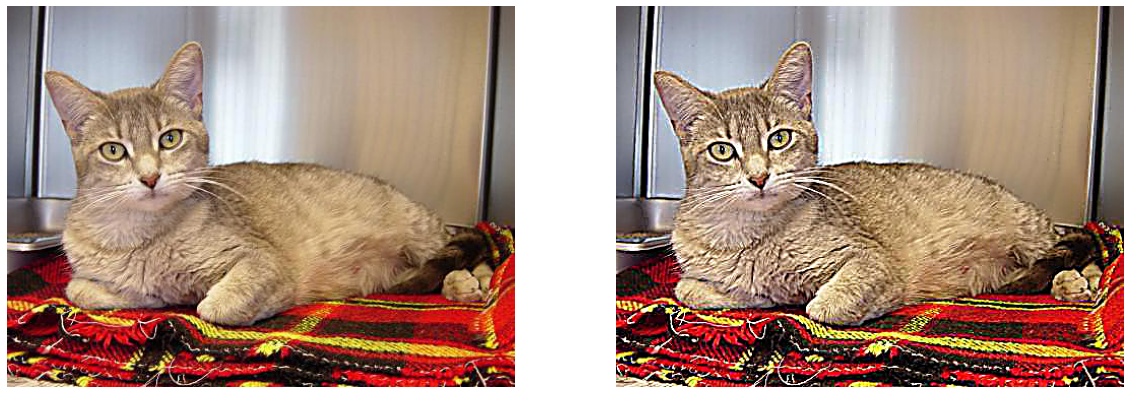

In [5]:
img = PIL.Image.open(sharped_train_cat_path / os.listdir(sharped_train_cat_path)[1])
img_new = img.filter(PIL.ImageFilter.UnsharpMask(radius=2, percent=150))
fig = plt.figure(1, figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(img_new)
plt.axis("off")

In [6]:
# 删除无法读取的格式图片
import os
from pathlib import Path

import PIL

path = Path(sharped_train_path).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
        os.remove(img_p)

In [8]:
# Data preprocessing

img_height = 224
img_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=0.1,
)  # set validation split

val_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
    sharped_train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
)  # set as training data

validation_generator = val_datagen.flow_from_directory(
    data_dir,  # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
)  # set as validation data

Found 22446 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [9]:
from tensorflow.keras import Model, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = "./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

pre_trained_model = InceptionV3(
    input_shape=(224, 224, 3), include_top=False, weights=None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
last_layer = pre_trained_model.get_layer("mixed7")
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(pre_trained_model.input, x)
model.summary()
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics="accuracy",
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    verbose=1,
)

Epoch 1/10
702/702 [==============================] - 242s 345ms/step - loss: 0.0630 - accuracy: 0.9882 - val_loss: 0.0852 - val_accuracy: 0.9808
Epoch 2/10
191/702 [=======>......................] - ETA: 2:56 - loss: 0.0381 - accuracy: 0.9920